# Estimating Colorado’s Housing Shortfall

Greg Totten (Colorado State Demography Office)

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

The duckplyr package is configured to fall back to dplyr when it encounters an
incompatibility. Fallback events can be collected and uploaded for analysis to
guide future development. By default, data will be collected but no data will
be uploaded.
ℹ Automatic fallback uploading is not controlled and therefore disabled, see
  `?duckplyr::fallback()`.
✔ Number of reports ready for upload: 59.
→ Review with `duckplyr::fallback_review()`, upload with
  `duckplyr::fallback_upload()`.
ℹ Configure automatic uploading with `duckplyr::fallback_config()`.
✔ Overwriting dplyr methods with duckplyr methods.
ℹ Turn off with `duckplyr::methods_restore()`.


Attaching package: 'srvyr'

The following object is masked from 'package:stats':

    filter


Attaching package: 'scales'

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor

The current file is a draft working version and should be recognized as such. All discussion and analysis should be considered preliminary and subject to change.

## Defining The Shortfall

In order to estimate the total housing shortfall in Colorado, we must first define the metrics by which we are going to assess the number of housing units the state might be short.

How these metrics are defined can have a significant impact on the resulting analysis. As a highly stylized example to demonstrate this concept let’s begin by using two examples to bound our estimates:

1.  Every person currently residing in the state does so inside of a permanent housing unit. In this scenario we would have a relatively low estimate of the total number of necessary housing units - as what would be required is enough units to house the state’s unhoused population. In this case the estimate of number housing units might just be the estimate of the number of people in this population. However, this could be reduced by changing our requirements of housing to include any shelter - such as tents as vehicles, which would likely bring the estimated much lower.
2.  Every current US resident who would like to live in Colorado may do so, and they will be able to do so for free. Conversely, in this scenario we might expect an estimate that is quite high, as while some people still may opt not to reside in our beautiful state (perhaps they do not particularly like sun), we could reasonably expect many Americans, perhaps into the hundreds of millions, might opt to spend no money to live in our beautiful state.

In between these two estimates are a range of scenarios that might be indicative of the number of housing units which are necessary - based on the objectives we are trying to determine, and the underlying assumptions about housing preferences which underlie them. In this paper we will examine a variety of methods, based primarily on studies by other researchers, that we can apply to Colorado to determine the estimated housing shortfall in the state, under that method. In this way we will provide not so much a point estimate of the total housing shortfall, but a range of estimates which can be utilized by planners and policy makers based on their discretion with respect to the reasonableness and applicability of each method. In doing so we also hope to plan a clear, concise, explanation of the method, what objective it is attempting to solve for, and the meaning of the estimate within that context.

## Data

Data primarily comes from the most recent American Community Survey (“ACS”) one year estimates for Colorado, and data from the Colorado State Demography Office (“SDO”). One year ACS estimates are primarily used as the population of the state is large enough to allow for the use of such estimates. If applying similar methodologies at smaller geography levels (such as county level), it may be necessary to instead use 5 year estimates. Additionally, some methods of deriving estimates, such as by analyzing Public Use Microdata Sample (“PUMS”) data may not be possible for all methods. As such many methods determined here may only be applicable at the state level.

## Examples

### Harvard Joint Center for Housing Studies Blog

One resource that compares four relatively recent national studies attempting to determine housing shortfalls are a January 2024 blog entry from the Harvard Joint Center for Housing Studies (“JHCS”) \[@mccue2024\]. The four studies each utilize different methodologies and resulting estimates covering different years. The four studies are:

1.  [National Association of Home Builders (NAHB) 2021](https://www.freddiemac.com/research/insight/20210507-housing-supply)
2.  [Freddie Mac 2020](https://www.freddiemac.com/research/insight/20210507-housing-supply)
3.  [National Association of Realtors (NAR) 2021](https://www.nar.realtor/advocacy/housing-is-critical-infrastructure)
4.  [National Low Income Housing Coalition (NLIHC)](https://nlihc.org/gap)

The following sections will provide estimates of the housing shortage in Colorado based on each of these study methodologies.

### National Association of Home Builders

The NAHB study estimates the national housing shortage by examining the difference in ACS vacancy rates in the current year from their long run average. This resulted in an estimated shortage of 1.5 million units.

The first step is to create a time series of vacancy rates for the state with ACS data. This data is accessed from the IPUMS USA database \[@ruggles2024a\] using the `ipumsr` package in R \[@ipumsr\].

In [ ]:
acs_samples <- get_sample_info("usa") |>
  filter(str_detect(name, pattern = "20\\d+a$")) |> 
  pull(name)

ipums_dir <- "data/ipums_raw/"
ipums_ddi <- "usa_00081.xml"
file_loc <- paste0(
  ipums_dir,
  ipums_ddi
)
  if (file.exists(file_loc)) {
    acs_ddi <- read_ipums_ddi(file_loc)
    acs_00_23 <- acs_ddi |>
      read_ipums_micro_list()
  } else {
acs_00_23 <- define_extract_micro(
      collection = "usa",
      description = "ACS 1 year samples in Colorado of vacancy variables",
      samples = acs_samples,
      variables = list(
        var_spec("STATEFIP", case_selections = "08"),
        "COUNTYFIP",
        "PUMA",
        "GQ",
        "OWNERSHP",
        "VACANCY",
        "REPWT",
        "AGE",
        "REPWTP"
      ),
      data_structure = "hierarchical",
    ) |>
      submit_extract() |>
      wait_for_extract() |>
      download_extract(download_dir = ipums_dir) |>
      read_ipums_micro()
  }

Use of data from IPUMS USA is subject to conditions including that users should cite the data appropriately. Use command `ipums_conditions()` for more details.

Vacancy rates are calculated based on both the `OWNERSHP` and `VACANCY` variables. Additionally the `GQ` variable is used to filter out group quarters.

In order to calculate vacancy rates it is necessary to first understand what each of the values for each variable represents

In [ ]:
# create acs_info from the DDI which includes variable information
acs_info <- ipums_var_info(acs_ddi)

# generate table with variable information
# table will include columns {VAR}_val, and {VAR}_lbl with the value and
# label for each variable. This is setup so tab_spanner_delim can be used to
# separate out columns in a GT table
acs_var_tbl <- acs_info |>
  # only include necessary variables
  filter(var_name %in% c('OWNERSHP', 'VACANCY', "GQ")) |>
  # remove other columns
  select(var_name, val_labels) |>
  # unnest labels from nested columns
  unnest(val_labels) |>
  # group by var_name for generating row numbers to unpivot without lists
  group_by(var_name) |>
  # add row_numbers
  mutate(row = row_number()) |>
  ungroup() |> 
  # pivot wider to generate table
  pivot_wider(
    names_from = var_name,
    values_from = c(val, lbl),
    # specify order of variable then val/lbl column
    names_glue = "{var_name}_{.value}",
    # use slowest so variables are grouped together
    names_vary = "slowest") |>
  # remove row index as no longer necessary
  select(-row) |> 
  # move GQ to end
  relocate(starts_with("GQ"), .after = last_col())

# create GT table with information
acs_var_tbl_gt <- acs_var_tbl |>
  gt() |> 
  # create spanners based on the column separators defined above
 tab_spanner_delim(delim = "_") |>
  # Replace NA values with empty strings
  sub_missing(
    missing_text = ""
  )

In [ ]:
# display table
acs_var_tbl_gt

@tbl-pums-vars includes the values and respective labels for each of the `OWNERSHP`, `VACANCY`, and `GQ` variables.

The N/A labels associated with `val=0` for the `OWNERSHP` and `VACANCY` variables is reflective of units which are Vacant, or Occupied, respectively.

Given these values we then need to establish filtering parameters for determining vacancy rates.

1.  `GQ <= 2 OR GQ ==5` filter out GQ units to only included Households and Vacant Units (including with the 1990 and 2000 Additional Unit definitions)[1].
2.  `VACANCY <=2` Remove occasional/seasonal vacant units (4-6) consistent with NAHB analysis. Remove migrant farm worker usage (7), and other vacant (9), as these should be relatively independent of overall vacancy rates. Reclassify `3` - Rented or sold but not (yet) occupied to `0` as occupied.
3.  Leave Ownership as is.

In order to broadly analyze survey data, and additionally calculate margin of error, the `srvyr` package is used. Prior to analysis a survey object must be defined based on the extracted ACS data. This survey object filters GQ units based on condition 1 above, and removes vacant units based on condition 2 above. Additionally, it reclassifies `VACANCY == 3` to `0` as occupied. Finally, `N/A` values are relabeled for each of the OWNERSHP, and VACANCY variables to reflect that these reflect Vacant and Occupied units, respectively.

[1] Note to self - review these definitions to see if we want to exclude any of these groupings.

In [ ]:
# create survey design object
acs_hh_data <- acs_00_23$HOUSEHOLD |> 
# remove GQ units and vacant units 4-6
  filter(
    GQ %in% c(0,1,2,5) & 
      !(VACANCY %in% c(4:6, 7, 9))
    ) |> 
  # reclassify 3 to 0 and 4-6 to 3
  mutate(
    VACANCY = lbl_relabel(
      VACANCY, 
      0 ~.val == 3
      ),
    OWNERSHP = lbl_relabel(
      OWNERSHP, 
      lbl(0, "Vacant") ~ .val == 0
      )
    ) |> 
      as_factor(levels = "values") |> 
      as_duckplyr_tibble()

ℹ Please use `as_duckdb_tibble()` instead.

Then total up on an annual basis the total occupied units each for sale and for rent, as well as vacant units by for sale or for rent[1]\[^margin of error are calculated as 1.645 \* standard error consistent with 90% CI\]. We additionally calculate total occupied and total vacant as the sum of each of these. Vacancy rates are then calculated as \$ VACANT\_{ot} \$ for each occupancy status $o$ and year $t$. Finally we calculate the sum total of occupied and vacant units for each year[2].

Once the vacancy rates are calculated, we then calculate the average vacancy rate for each year. To get an annual shortfall we then take the difference between the average vacancy rate and the current vacancy rate. Applying this difference to the total number of units for each year gives us the annual shortfall.

In combining vacancy rates a `tenure` variable is created to determine if a unit is determined to be sale or rental for the purpose of calculating vacancy rates. This is set equal to the value `rent` for `OWNSHP == 2` and `VACANCY == 1`, and `own` for `OWNSHP == 1` and `VACANCY == 2`; consistent with the classifications determined above.

[1] For this purpose we make the assumption that `VACANCY == 1` (For rent or sale) is for Rent, and `VACANCY ==2` (For sale only) is for sale in order to the simplify the analysis.

[2] Note to self - verify that margin of error are additive

In [ ]:
# calculate vacancy
acs_vacancy <- acs_hh_srvy |>
  group_by(VACANCY, YEAR) |>
  survey_count(VACANCY, name = "vac") |>
  mutate(
    vac_moe = vac_se *1.645,
    tenure = case_when(
      VACANCY == 1 ~ "rent",
      VACANCY == 2 ~ "own"
    )
  ) |>
  filter(!is.na(tenure)) |>
  ungroup()

# calculate occupied
acs_occupancy <- acs_hh_srvy |>
  group_by(OWNERSHP, YEAR) |>
  survey_count(OWNERSHP, name = "occ") |>
  mutate(
    occ_moe = occ_se *1.645,
    tenure = case_when(
      OWNERSHP == 1 ~ "own",
      OWNERSHP == 2 ~ "rent"
    )
  )|>
  filter(!is.na(tenure)) |>
  ungroup()

# calculate total occupied and total vacant
acs_combined_ov <- acs_vacancy |>
  select(YEAR, tenure, vac, vac_moe) |>
  left_join(acs_occupancy |>
              select(YEAR, tenure, occ, occ_moe),
            by = c("YEAR", "tenure")) %>% # old style pipe needs to be used to pipe . into bind_rows
  bind_rows(
    summarize(
      .,
      tenure = "total",
      across(c(vac:occ_moe), sum),
      .by = YEAR)
  ) |>
  mutate(
    total = vac + occ,
    vac_rate = vac/total
  ) |>
  group_by(tenure) |>
  mutate(avg_vac_rate = mean(vac_rate)) |>
  ungroup() |>
  mutate(
    diff_from_avg = avg_vac_rate - vac_rate,
    shortfall = diff_from_avg * total)

current_shortfall <- acs_combined_ov |>
  filter(YEAR == 2023) |>
  select(-YEAR) |>
  mutate(tenure = str_to_title(tenure)) |>
  gt() |>
  fmt_number(c(vac:total, shortfall), decimals = 0) |>
  fmt_percent(c(vac_rate:diff_from_avg)) |>
  cols_label(
    tenure = "Tenure",
    vac = "Vacant",
    vac_moe = "Margin of Error",
    occ = "Occupied",
    occ_moe = "Margin of Error",
    total = "Total",
    vac_rate = "Vacancy Rate",
    avg_vac_rate = "Average Vacancy Rate",
    diff_from_avg = "Difference from Average",
    shortfall = "Shortfall"
  ) |>
  cols_align("center")

In [ ]:
current_shortfall
# define get_shortfall function to return shortfall based on tenure and format data
extract_shortfall <- function (ten_type) {
  current_shortfall |>
    fmt_number(decimals = 1, suffixing = "K") |>
    extract_cells(shortfall, rows = tenure == ten_type)
}

@tbl-nahb-shortfall contains the calculated shortfall for 2023 using the NAHB methodology. Using this methodology shortfalls of 15.4K units for rent and 13.5K units for ownership are determined, for a total shortfall of 27.7K[1].

### Freddie Mac

Freddie Mac determines the Target Housing Stock `k*` as a function of target number of households `hh*`, and target vacancy rate `v*`, as provided in \[@eq-freddie-mac-housing-units; @khater2021\].

$$
k^* = {{hh^*}\over{1-v^*}}
$$ {#eq-freddie-mac-housing-units}

Target households are based on target headship rates according to the methods used in the 2018 Freddie Mac analysis. This analysis calculates target households based on 5 year age groups from the 1994-2018 Current Population Survey-Annual Social and Economic Supplement for target number of households $hh^*$, based on population $pop_i$ and headship rate $hr_i^*$ as provided in \[@eq-freddie-mac-headship-rate; @khater2018\].

$$ 
{hh^*}= \sum_{i=15}^{65+}pop_i^*hr_i^*
$$ {#eq-freddie-mac-headship-rate}

In their analysis the target headship rate is adjusted based on factors for housing costs, income, and employment, adjusting for the contribution of each using a Oaxaca-Blinder decomposition to determine the relative contribution of each factor. \[@khater2018\]

In this analysis we simplify the target headship rate to be the average headship rate of the population from 2000-2023, based on our dataset above. We calculate these headship rates by similarly bucketing households based on 5 year age groups from 15-19 to 65+ and calculating the headship rate for each group, where headship rate in year $t$, $hr_{it}$, is calculated as the number of households with a head of household in age group $i$ divided by the total number of households in age group $i$, as provided in @eq-headship-rate. We then calculate the average headship rate for each group across the years 2000-2023, which is used as the target headship rate.

$$
hr_{it} = {{hh_{it}}\over{pop_{it}}}
$$ {#eq-headship-rate}

[1] Note: the Total shortfall is less than the sum of the own and vacant shortfalls due to differences as vacancy rates are determined by tenure.

In [ ]:
# Calculate headship rates for each age group for each year from 2000-2023
acs_hr_data <- acs_00_23$PERSON |>
  zap_labels(AGE) |>
  as_factor() |>
  as_duckplyr_tibble() |>
  # join GQ data from household level to person level
  left_join(acs_hh_data |>
              select(YEAR, SERIAL, GQ), by = c("YEAR", "SERIAL")) |>
  filter(GQ %in% c(1, 2, 5)) |>
  # create age bins
  mutate(
    # generate age breaks for cuts
    age_bin = cut(
      AGE,
      breaks = c(15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, Inf),
      right = FALSE
    ),
    # flag head of household
    head_of_household = ifelse(PERNUM == 1, 1, 0)
  )

acs_hr_srvy <- acs_hr_data |>
  # create survey object from acs_hr_data dataframe
  as_survey_design(
    weight = PERWT,
    repweights = matches("REPWTP[0-9]+"),
    type = "ACS",
    mse = TRUE
  )

# calculate headship rates for each age group for each year from 2000-2023
acs_hr_totl_persons <- acs_hr_srvy |>
  survey_count(YEAR, age_bin, name = "total_persons")

acs_hr_hh_heads <- acs_hr_srvy |>
  filter(PERNUM == 1) |>
  survey_count(YEAR, age_bin, name = "total_hh")

calc_headship_rates <- function(end_year) {
  acs_hr_hh_heads |>
    left_join(acs_hr_totl_persons, by = c("YEAR", "age_bin")) |>
    mutate(hr = total_hh / total_persons) |>
    group_by(age_bin) |>
    mutate(target_hr = mean(hr[YEAR <= end_year])) |>
    ungroup() |>
    mutate(target_hh = target_hr * total_persons,
           missing_hh = target_hh - total_hh) %>%
    bind_rows(
      summarize(
        .,
        age_bin = "total",
        across(c(
          total_hh:total_persons_se, target_hh, missing_hh
        ), sum),
        hr = total_hh / total_persons,
        target_hr = target_hh / total_persons,
        .by = YEAR
      )
    ) |>
    mutate(end_year = end_year, .before = 1)
}

acs_headship_rates <- calc_headship_rates(2015)

Using this analysis we find that the target number of households based on target headship rates is extremely sensitive to the end year of the target period. To demonstrate this we run the analysis based on end years of 2010, 2015, and 2020, showing the results for the “total” age_bin.

In [ ]:
headship_rates_by_end_year <-
  map(c(2010, 2015, 2020), calc_headship_rates) |>
  bind_rows() |>
  filter(age_bin == "total" & YEAR == 2023) |>
  select(-YEAR, -age_bin) |>
  gt() |>
  fmt_number(!end_year, decimals = 0) |>
  fmt_percent(hr:target_hr) |>
  cols_align("center") |>
  cols_label(
    end_year = "End Year",
    total_persons = "Total Persons",
    total_hh = "Total Households",
    target_hh = "Target Households",
    missing_hh = "Missing Households",
    hr = "Headship Rate",
    target_hr = "Target Headship Rate",
    total_hh_se = "Standard Error",
    total_persons_se = "Standard Error"
  )

headship_rates_by_end_year

This is largely driven by the large increase in headship rates beginning around 2006, as seen in @fig-headship-rates.

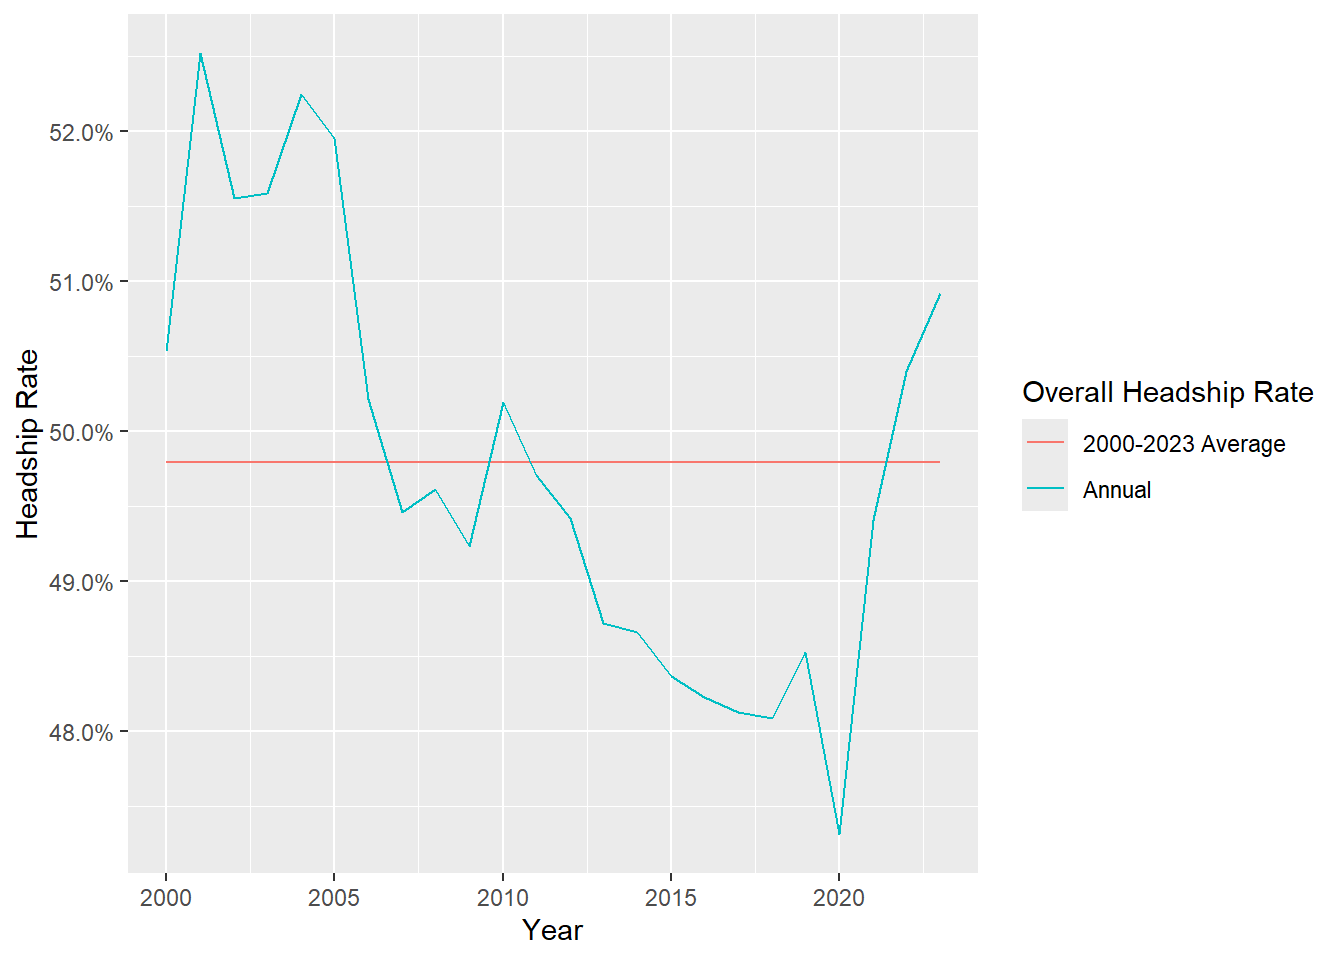

In [ ]:
acs_headship_rates |> 
  filter(age_bin == "total") %>%
  bind_rows(
    expand_grid
    (YEAR = 2000:2023,
      summarize(
        .,
        age_bin = "avg",
        hr = mean(hr)
        )
      )
    ) |> 
  ggplot(
    aes(
      x = YEAR, 
      y = hr, 
      color = age_bin
      )
    ) +
  geom_line() +
  scale_y_continuous(
    labels = label_percent()
  ) +
  labs(
    x = "Year",
    y = "Headship Rate",
    color = "Overall Headship Rate"
  ) +
  scale_color_discrete(
    labels = c(
      "avg" = "2000-2023 Average",
      "total" = "Annual"
    )
  )

### National Association of Realtors

This uses the decline in building rates during the 2000s relative to the long term averages between 1968 and 2000 to determine the shortfall in housing from the supply side. This method was not recreated due to the inherent underlying assumptions. In particular, growth rates are not necessarily linear over time, and this is particularly the case with rapidly growing states. Colorado in particular was undergoing rapid urbanization and it is not necessarily safe to assume that growth of this style would continue.

### National Low Income Housing Coalitition (NLIHC)

This calculates the housing gap based on the difference between households by AMI (extremely low-income, very low-income, low-income, middle-income, or above median income), based on the applicable HUD AMI. Housing Units were separately categorized into income necessary to rent them, based on spending more than 30% of their income on housing costs (regardless of the actual income of the household occupying that housing unit). Finally they examined the extent to which households in each AMI group resided in a unit which was affordable to that household. \[@thegap2024\]

While this methodology is similar to the method SDO is currently working as part of its Housing Needs Assessments there is no need to recreate the table directly, as NLIHC provides state level results for all states, including [Colorado](https://nlihc.org/gap/state/co), based on 2022 ACS data.

Based on their methodology NLIHC finds Colorado to be short 119,782 housing units at the Extremely Low Income (0 to 30% of Area Median Income), and 165,053 units for households at or below 50% AMI (including those who were classified as Extremely Low Income. While statewide they find that there are 101 Affordable and Available Rental Units per 100 Households for those At or Below 100% AMI, there are only 27 and 44 units Affordable and Available to those at or below the 30% and 50% AMI levels, respectively. Similarly they find that for households which are in the 0-30%, and 31-50% AMI bands, 88% and 83% units, respectively are Cost Burdened, while only 22% of units between 81 and 100% AMI are. \[@gaprepo\]

One important footnote to the NLIHC study, however, is that the units identified are not necessarily new housing units which must be built. Rather they indicate households that may reside in housing units already, but for which the cost may be unaffordable. This distinction is important because the housing already exists, and the objective then is to determine a method for making these units affordable to these families, which can occur in different ways, including by subsidizing rents for residents to bridge the gap between 30% of their income and the market rent being charged on their unit. Additionally, because housing prices are determined on the margins, each additional housing unit in theory pushes down housing prices by some incremental amount, holding demand equal. Therefore the number of units necessary to push prices down to a level which becomes affordable to residents at these costs is not necessarily equal to the total number of households experience affordability problems, and, in fact, may be significantly higher or lower depending on these effects and the manner to which lower rents filter down through the housing stock.